PICHARD Gregoire

## Question 1

In [1]:
import numpy as np
from qat.lang.AQASM import Program, H,  AbstractGate, QRoutine, CNOT
from scipy import linalg # for linalg.expm, the matrix exponential.
from qat.qpus import get_default_qpu # numerical simulator for small quantum circuits.

prog = Program() 
q = prog.qalloc(2)
prog.apply(H, q[0]) #Hadamar first qubit


def matrix(theta):
    X = np.array([[0,1],[1,0]])
    return linalg.expm(-1j * theta * X)

ham_x = AbstractGate("ham_X", [float], arity=1, matrix_generator=matrix) # definition of a custom parametrized gate
prog.apply(ham_x(0.3).ctrl(), q) #Ham_x 
circ = prog.to_circ() # The program is exported into a circuit.  
# displaying the circuit:
%qatdisplay --svg circ


## Simulation
qpu = get_default_qpu()
job = circ.to_job() # options could be fed here. choosing the default, like here, means
# that we want to compute the amplitude/probability of all possible states.
result = qpu.submit(job)
for sample in result:
    print("State %s: probability %s, amplitude %s" % (sample.state, sample.probability, sample.amplitude))

State |00>: probability 0.4999999999999999, amplitude (0.7071067811865475+0j)
State |10>: probability 0.4563339037274195, amplitude (0.6755249097756644+0j)
State |11>: probability 0.043666096272580425, amplitude -0.20896434210788314j


### Hamiltonian data

The purpose of the TP is to reproduce, using numerical simulation, Figure 3.(a) of https://arxiv.org/abs/1512.06860.

On this figure, the ground state energy of a dihydrogen molecule is plotted against the distance $R$ separating the hydrogen atoms. It allows to predict the **equilibrium bond length** of the molecule.

*Note*: In more complicated settings with larger molecules, energy may be plotted against various distances and angles, forming an *energy landscape* that proves useful in predicting chemical reaction mechanisms, rates, etc.

The cell below imports the data of Table I of https://arxiv.org/abs/1512.06860.

In [2]:
#importing Hamiltonian data.
import json 

with open('hamiltonian_data.json','r') as f:
    ham_data = json.load(f)
    
for coeffs in ham_data:
    print(coeffs)
    
test = ham_data[0]
print(test["I_coeff"])

{'R': 0.2, 'I_coeff': 2.8489, 'Z0_coeff': 0.5678, 'Z1_coeff': -1.4508, 'Z0Z1_coeff': 0.6799, 'X0X1_coeff': 0.0791, 'Y0Y1_coeff': 0.0791, 't0': 0.0791}
{'R': 0.25, 'I_coeff': 2.1868, 'Z0_coeff': 0.5449, 'Z1_coeff': -1.287, 'Z0Z1_coeff': 0.6719, 'X0X1_coeff': 0.0798, 'Y0Y1_coeff': 0.0798, 't0': 0.0798}
{'R': 0.3, 'I_coeff': 1.7252, 'Z0_coeff': 0.5215, 'Z1_coeff': -1.1458, 'Z0Z1_coeff': 0.6631, 'X0X1_coeff': 0.0806, 'Y0Y1_coeff': 0.0806, 't0': 0.0806}
{'R': 0.35, 'I_coeff': 1.3827, 'Z0_coeff': 0.4982, 'Z1_coeff': -1.0226, 'Z0Z1_coeff': 0.6537, 'X0X1_coeff': 0.0815, 'Y0Y1_coeff': 0.0815, 't0': 0.0815}
{'R': 0.4, 'I_coeff': 1.1182, 'Z0_coeff': 0.4754, 'Z1_coeff': -0.9145, 'Z0Z1_coeff': 0.6438, 'X0X1_coeff': 0.0825, 'Y0Y1_coeff': 0.0825, 't0': 0.0825}
{'R': 0.45, 'I_coeff': 0.9083, 'Z0_coeff': 0.4534, 'Z1_coeff': -0.8194, 'Z0Z1_coeff': 0.6336, 'X0X1_coeff': 0.0835, 'Y0Y1_coeff': 0.0835, 't0': 0.0835}
{'R': 0.5, 'I_coeff': 0.7381, 'Z0_coeff': 0.4325, 'Z1_coeff': -0.7355, 'Z0Z1_coeff': 0.6233,

### Question 2:
Following the QRoutine minimal example below, implement QRoutines for each of the Hamiltonian evolutions we need.


#### QRoutine: minimal example

In [3]:
from qat.lang.AQASM import RZ
def f(dt):
    
    routine = QRoutine()
    
    routine.apply(RZ(dt), 0)            # like a Program, except that gates are applied to "wires" 
    routine.apply(CNOT, 0, 1)      # numbered from 0 to the max number that has been seen.
    routine.apply(H, 0)
    
    return routine

#Pasting it into a circuit

prog = Program()

q = prog.qalloc(4)

a = f(0.1)

prog.apply(a, q[:2])
prog.apply(f(0.2), q[1:3])
prog.apply(f(0.3).ctrl(), q[1:]) #Controlled version

circ = prog.to_circ()

%qatdisplay --svg circ        

#### Hamiltonian evolutions to implement

In [4]:
from qat.lang.AQASM import CNOT, RZ, RX, RY, S, I

def u_11_matrix(dt):
    # needed for accurate energy values.
    return np.diag([np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt)])

U_II = AbstractGate("II",[float],arity=2,matrix_generator=u_11_matrix)
    
def U_ZZ(dt):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(2*dt), 1) 
    zz_r.apply(CNOT, 0, 1)

    return zz_r

#Implement, as above, all the other hamiltonian simulations here.
def U_ZI(dt):
    zI_r = QRoutine()
    zI_r.apply(RZ(2*dt), 0)
    zI_r.apply(I, 1) 
    return zI_r

def U_IZ(dt):
    Iz_r = QRoutine()
    Iz_r.apply(I, 0)
    Iz_r.apply(RZ(2*dt), 1)
    return Iz_r

def U_XX(dt):
    xx_r = QRoutine()
    xx_r.apply(CNOT, 0, 1)
    xx_r.apply(RX(2*dt), 0) 
    xx_r.apply(CNOT, 0, 1)

    return xx_r

def U_YY(dt):
    yy_r = QRoutine()
    yy_r.apply(S.dag(),1)
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(RY(2*dt), 0)
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(S,1)

    return yy_r
    
check = True # turn true to plot and see what you do

if check:
    prog = Program()
    q = prog.qalloc(2)
    prog.apply(U_ZI(0.3), q)
    circ = prog.to_circ()

    #uncomment following line to plot circuit
    %qatdisplay --svg circ
    
print(I)

### Question 3:
Implement a function returning a Qroutine implementing a Trotterized evolution generated by our Hamiltonian.

In [6]:
def trotter_ham_simulation(ham_coeffs, dt, p, shift):
    """
    Args:
        - ham_coeffs: a dictionary from the list of dictionaries loaded from hamiltonian_data.json.
        Therefore its keys are "I_coeff", "Z0_coeff", etc.
        - dt: a float, corresponding to the interval of time whose value we will define later.
        - p: the "Trotter number": the integer controlling the degree of approximation
        - shift: an energy shift to the Hamiltonian to make sure that the value of the ground state energy
        is positive. It consists in adding +shift*I to the Hamiltonian.
    """
    # Here we select the g_i coeffs from ham_coeffs for a given R
    g0 = ham_coeffs["I_coeff"]
    g1 = ham_coeffs["Z0_coeff"]
    g2 = ham_coeffs["Z1_coeff"]
    g3 = ham_coeffs["Z0Z1_coeff"]
    g4 = ham_coeffs["Y0Y1_coeff"]
    g5 = ham_coeffs["X0X1_coeff"]
    qroutine = QRoutine()
    for i in range(0,p):
        qroutine.apply(U_XX(g5*dt/p),0, 1)
        qroutine.apply(U_YY(g4*dt/p),0, 1)
        qroutine.apply(U_ZZ(g3*dt/p),0, 1)
        qroutine.apply(U_IZ(g2*dt/p),0, 1)
        qroutine.apply(U_ZI(g1*dt/p),0, 1)
        qroutine.apply(U_II((g0+shift)*dt/p),0, 1) # we don't forget the schift term
        
            
    return qroutine

In [7]:
# IDEAL HAMILTONIAN SIMULATION: we will use it to compare to the Trotterized version.
def perfect_ham_simulation(ham_coeffs, dt, shift):

    I = np.eye(4)
    Z0 = np.diag([1,1,-1,-1])
    Z1 = np.diag([1,-1,1,-1])
    Z0Z1 = np.diag([1,-1,-1,1])
    X0X1= np.fliplr(np.eye(4))
    Y0Y1 = np.fliplr(np.diag([-1, 1, 1, -1]))

    H = (ham_coeffs['I_coeff']+shift) * I
    H += ham_coeffs['Z0_coeff'] * Z0
    H += ham_coeffs['Z1_coeff'] * Z1
    H += ham_coeffs['Z0Z1_coeff'] * Z0Z1
    H += ham_coeffs['X0X1_coeff'] * X0X1
    H += ham_coeffs['Y0Y1_coeff'] * Y0Y1

    U = linalg.expm(-1j * dt * H)

    def matrix():
        return U

    U_gate = AbstractGate("U", [], arity=2,
                     matrix_generator=matrix)

    qroutine = QRoutine()

    qroutine.apply(U_gate(), 0, 1)

    return qroutine

### Question 4: Implement iterative phase estimation
As a function taking as input an Hamiltonian and execution parameters, and returning a phase.

In [8]:
from qat.lang.AQASM import X

E_max = 3
E_min = -2
    
dt = (2 * np.pi) / float(E_max)

def phase(coeffs, trotterization=False, trotter_number=4, shift=-E_min, nBits = 10):
    """
    Given Hamiltonian coefficients, compute phi, s.t U|\psi\rangle = e^{-2i\pi\phi}|\psi\rangle
    
    Args:
        - coeffs: a dictionary of coefficients as extracted from the list of dictionaries loaded
        from hamiltonian_data.json
        - trotterization: Boolean flag specifying whether to use the Trotterized evolution or the
        ideal "cheat mode" which exponentiates the Hamiltonian.
        - trotter_number: the "p" controlling the degree of approximation of the Trotterization.
        - shift: the energy shift that we use to make sure that the phase we compute is 0 < phi < 1
        - nBits: The number of precision bits we compute.
        
    Returns:
        - phi, a real number that should fall between 0 and 1.
    """
    bits = {}
    prog = Program()
    q = prog.qalloc(3)
    
    for k in range(nBits, 0, -1):
       
        # we calculate Phi_k :
        phi = 0
        for i in range(k+1,nBits+1):
            phi = phi +2*np.pi*bits[i]/(2**(i-k+1))
            
        # CIRCUIT CREATION
        # Put your implementation here. Paste here the QRoutines 
        prog.apply(H, q[0])
        
        # to have the ground state |10> :
        prog.apply(X, q[1])
        prog.apply(I, q[2])
        
        # applying trotterization or ideal version
        if trotterization==False:
            prog.apply(perfect_ham_simulation(coeffs, 2**(k-1)*dt, shift).ctrl(), q[0:])
        else:
            prog.apply(trotter_ham_simulation(coeffs, 2**(k-1)*dt, trotter_number, shift).ctrl(), q[0:])
            
        prog.apply(RZ(phi), q[0])
        prog.apply(H, q[0])
        
        # CIRCUIT SIMULATION
        qpu = get_default_qpu()
        circ = prog.to_circ()
        job = circ.to_job()
        result = qpu.submit(job)

        # SELECTION OF MOST LIKELY RESULT 
        # Put your implementation here
        list_probability = [sample.probability for sample in result] # list of probability
        list_state = [sample.state for sample in result] # list of states
        value_max = max(list_probability) # get the highest probability
        index_max = list_probability.index(value_max) # find corresponding index
        state = list_state[index_max] # find corresponding state
        max_state = int(state[0])  # take the first qubit only
        
        bits[k] = max_state
           
    # recompute phi
    phi = 0
    for i in range(1,nBits+1):
        phi = phi +2*np.pi*bits[i]/(2**(i-1))
        
    return phi

### Question 5: Plot dissociation curves
Call the function you defined above to compute phases for each values of R. Convert them back to energies, and plot the result for two different Trotter number values: 4 and 10. Both should be wiggly approximations to the ideal curve, but 10 should be closer to it.

In [20]:
vals_perfect = []
vals_trotter_4 = []
vals_trotter_10 = []
Rs = []

shift = -E_min

for coeffs in ham_data:
    phi_perfect = phase(coeffs)
    phi_trotter_4 = phase(coeffs, trotterization=True, trotter_number=4)
    phi_trotter_10 = phase(coeffs, trotterization=True, trotter_number=10)
    
    print('phi_perfect',phi_perfect)

    # CONVERT PHASES BACK TO ENERGY
    E = 2 * np.pi * phi_perfect/dt
    E_trotter_4 = 2 * np.pi * phi_trotter_4/dt
    E_trotter_10 = 2 * np.pi * phi_trotter_10/dt
    
    print("R", coeffs['R'])
    Rs.append(coeffs['R'])
    
    vals_perfect.append(E)
    vals_trotter_4.append(E_trotter_4)
    vals_trotter_10.append(E_trotter_10)


phi 0
phi 0.0
phi 0.0
phi 0.0
phi 1.5707963267948966
phi 2.356194490192345
phi 1.1780972450961724
phi 2.1598449493429825
phi 1.0799224746714913
phi 0.5399612373357456
phi 0
phi 1.5707963267948966
phi 2.356194490192345
phi 2.748893571891069
phi 1.3744467859455345
phi 0.6872233929727672
phi 1.9144080232812801
phi 0.9572040116406401
phi 0.47860200582032003
phi 1.8100973297050564
phi 0
phi 1.5707963267948966
phi 2.356194490192345
phi 1.1780972450961724
phi 0.5890486225480862
phi 1.8653206380689396
phi 0.9326603190344698
phi 2.0371264863121312
phi 2.5893595699509624
phi 2.865476111770378
phi_perfect 7.3631077818510775
R 0.2
phi 0
phi 0.0
phi 1.5707963267948966
phi 2.356194490192345
phi 2.748893571891069
phi 1.3744467859455345
phi 2.2580197197676637
phi 2.6998061866787286
phi 2.9206994201342606
phi 1.4603497100671303
phi 0
phi 0.0
phi 0.0
phi 0.0
phi 0.0
phi 0.0
phi 0.0
phi 0.0
phi 1.5707963267948966
phi 2.356194490192345
phi 0
phi 1.5707963267948966
phi 2.356194490192345
phi 1.1780972450961

phi 0
phi 1.5707963267948966
phi 0.7853981633974483
phi 0.39269908169872414
phi 0.19634954084936207
phi 0.09817477042468103
phi 0.04908738521234052
phi 0.02454369260617026
phi 1.5830681730979816
phi 0.7915340865489908
phi_perfect 12.259574456782044
R 0.85
phi 0
phi 1.5707963267948966
phi 0.7853981633974483
phi 0.39269908169872414
phi 1.7671458676442586
phi 0.8835729338221293
phi 2.012582793705961
phi 1.0062913968529805
phi 2.073942025221387
phi 2.6077673394055902
phi 0
phi 0.0
phi 1.5707963267948966
phi 0.7853981633974483
phi 0.39269908169872414
phi 1.7671458676442586
phi 0.8835729338221293
phi 2.012582793705961
phi 2.5770877236478773
phi 2.859340188618835
phi 0
phi 1.5707963267948966
phi 2.356194490192345
phi 2.748893571891069
phi 2.945243112740431
phi 1.4726215563702154
phi 2.307107104980004
phi 2.724349879284899
phi 2.9329712664373457
phi 3.037281960013569
phi_perfect 5.2155346788111805
R 0.9
phi 0
phi 1.5707963267948966
phi 2.356194490192345
phi 2.748893571891069
phi 2.945243112740

phi 0.7853981633974483
phi 0.39269908169872414
phi 1.7671458676442586
phi 0.8835729338221293
phi 2.012582793705961
phi 2.5770877236478773
phi 2.859340188618835
phi 3.000466421104314
phi_perfect 12.284118149388213
R 1.5
phi 0
phi 0.0
phi 1.5707963267948966
phi 0.7853981633974483
phi 1.9634954084936207
phi 0.9817477042468103
phi 2.061670178918302
phi 1.030835089459151
phi 2.086213871524472
phi 1.043106935762236
phi 0
phi 0.0
phi 0.0
phi 1.5707963267948966
phi 0.7853981633974483
phi 1.9634954084936207
phi 0.9817477042468103
phi 0.4908738521234052
phi 0.2454369260617026
phi 0.1227184630308513
phi 0
phi 0.0
phi 0.0
phi 1.5707963267948966
phi 0.7853981633974483
phi 0.39269908169872414
phi 1.7671458676442586
phi 2.454369260617026
phi 2.7979809571034093
phi 2.969786805346601
phi_perfect 8.36939917870406
R 1.55
phi 0
phi 0.0
phi 0.0
phi 1.5707963267948966
phi 0.7853981633974483
phi 0.39269908169872414
phi 1.7671458676442586
phi 0.8835729338221293
phi 0.44178646691106466
phi 1.7916895602504288
p

phi 2.748893571891069
phi 2.945243112740431
phi 3.043417883165112
phi 1.521708941582556
phi 0.760854470791278
phi 0.380427235395639
phi 1.761009944492716
phi 0
phi 1.5707963267948966
phi 2.356194490192345
phi 1.1780972450961724
phi 2.1598449493429825
phi 1.0799224746714913
phi 0.5399612373357456
phi 1.8407769454627694
phi 0.9203884727313847
phi 0.46019423636569234
phi_perfect 9.203884727313847
R 2.2
phi 0
phi 1.5707963267948966
phi 2.356194490192345
phi 2.748893571891069
phi 2.945243112740431
phi 3.043417883165112
phi 3.0925052683774523
phi 3.1170489609836225
phi 3.1293208072867076
phi 1.5646604036433538
phi 0
phi 1.5707963267948966
phi 0.7853981633974483
phi 0.39269908169872414
phi 0.19634954084936207
phi 0.09817477042468103
phi 0.04908738521234052
phi 1.5953400194010667
phi 2.36846633649543
phi 2.7550294950426117
phi 0
phi 1.5707963267948966
phi 0.7853981633974483
phi 1.9634954084936207
phi 0.9817477042468103
phi 2.061670178918302
phi 1.030835089459151
phi 0.5154175447295755
phi 0.25

phi 2.6016314162540475
phi 1.3008157081270237
phi 0.6504078540635119
phi 0
phi 1.5707963267948966
phi 0.7853981633974483
phi 0.39269908169872414
phi 1.7671458676442586
phi 0.8835729338221293
phi 2.012582793705961
phi 2.5770877236478773
phi 1.2885438618239387
phi 0.6442719309119693
phi_perfect 5.583690067903734
R 2.85


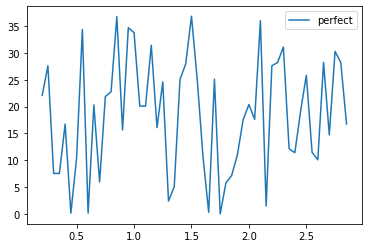

In [64]:
import matplotlib.pylab as plt

plt.plot(Rs, vals_perfect, label="perfect")
#plt.plot(Rs, vals_trotter_4, label="p=4")
#plt.plot(Rs, vals_trotter_10, label="p=10")
plt.legend()